In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
import pytz
import matplotlib.pyplot as plt
from scipy.stats import gmean

In [2]:
def allprint(df):
    """
    pandas DataFrame의 모든 행과 모든 열을 제한 없이 출력하는 함수.
    사용 후 원래 display 설정을 복원함.
    """
    # 현재 설정값 백업
    old_max_rows = pd.get_option('display.max_rows')
    old_max_cols = pd.get_option('display.max_columns')
    
    try:
        # 임시로 최대 행/열 출력 제한 해제
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        
        display(df)
    finally:
        # 함수 종료 후 원래 설정 복원
        pd.set_option('display.max_rows', old_max_rows)
        pd.set_option('display.max_columns', old_max_cols)


In [3]:
# 선우에게 받은 서울 외국환 중개 데이터터

In [4]:
usd_krw_spot=pd.read_pickle('data/SMB(20240312-20250312).pkl')
usd_krw_spot.index= pd.to_datetime(usd_krw_spot.index)
usd_krw_spot


KRWE=KFTC            HIGH_1   LOW_1  OPEN_PRC  TRDPRC_1  NUM_MOVES  \
Timestamp                                                            
2024-03-12 09:00:00  1312.0  1311.0    1311.0    1311.6         20   
2024-03-12 09:01:00  1311.8  1310.7    1311.7    1310.8         82   
2024-03-12 09:02:00  1311.0  1310.4    1311.0    1310.4         59   
2024-03-12 09:03:00  1310.8  1310.3    1310.4    1310.7         49   
2024-03-12 09:04:00  1310.6  1310.4    1310.6    1310.5         41   
...                     ...     ...       ...       ...        ...   
2025-03-12 00:53:00    <NA>    <NA>      <NA>      <NA>       <NA>   
2025-03-12 00:54:00    <NA>    <NA>      <NA>      <NA>       <NA>   
2025-03-12 00:55:00    <NA>    <NA>      <NA>      <NA>       <NA>   
2025-03-12 00:59:00    <NA>    <NA>      <NA>      <NA>       <NA>   
2025-03-12 01:00:00    <NA>    <NA>      <NA>      <NA>       <NA>   

KRWE=KFTC            BID_HIGH_1  BID_LOW_1  OPEN_BID     BID  BID_NUMMOV  \
Timestamp                                                                  
2024-03-12 09:00:00      1311.8     1310.0    1310.0  1311.6          40   
2024-03-12 09:01:00      1311.8     1310.7    1311.6  1310.8          68   
2024-03-12 09:02:00      1311.0     1310.3    1310.8  1310.4          63   
2024-03-12 09:03:00      1310.8     1310.2    1310.3  1310.6          47   
2024-03-12 09:04:00      1310.5     1310.3    1310.5  1310.5          42   
...                         ...        ...       ...     ...         ...   
2025-03-12 00:53:00      1453.3     1453.3    1453.3  1453.3           3   
2025-03-12 00:54:00      1453.3     1453.3    1453.3  1453.3           4   
2025-03-12 00:55:00      1453.3     1453.3    1453.3  1453.3           2   
2025-03-12 00:59:00      1453.3     1453.3    1453.3  1453.3           1   
2025-03-12 01:00:00      1453.3     1453.3    1453.3  1453.3           1   

KRWE=KFTC            ASK_HIGH_1  ASK_LOW_1  OPEN_ASK     ASK  ASK_NUMMOV  \
Timestamp                                                                  
2024-03-12 09:00:00      1313.0     1311.1    1313.0  1311.7          39   
2024-03-12 09:01:00      1311.9     1310.8    1311.8  1311.0          68   
2024-03-12 09:02:00      1311.1     1310.4    1311.1  1310.5          63   
2024-03-12 09:03:00      1310.9     1310.3    1310.5  1310.7          47   
2024-03-12 09:04:00      1310.7     1310.4    1310.7  1310.6          42   
...                         ...        ...       ...     ...         ...   
2025-03-12 00:53:00      1455.6     1454.3    1455.6  1454.3           3   
2025-03-12 00:54:00      1455.6     1454.3    1455.6  1454.3           4   
2025-03-12 00:55:00      1454.2     1454.1    1454.2  1454.1           2   
2025-03-12 00:59:00      1454.0     1454.0    1454.0  1454.0           1   
2025-03-12 01:00:00      1455.6     1455.6    1455.6  1455.6           1   

KRWE=KFTC            MID_HIGH  MID_LOW  MID_OPEN  MID_PRICE  
Timestamp                                                    
2024-03-12 09:00:00    1311.9   1310.0    1310.0    1311.65  
2024-03-12 09:01:00   1311.85  1310.75    1311.7     1310.9  
2024-03-12 09:02:00   1311.05  1310.35   1310.95    1310.45  
2024-03-12 09:03:00   1310.85  1310.25    1310.4    1310.65  
2024-03-12 09:04:00    1310.6  1310.35    1310.6    1310.55  
...                       ...      ...       ...        ...  
2025-03-12 00:53:00   1454.45   1453.8   1454.45     1453.8  
2025-03-12 00:54:00   1454.45   1453.8   1454.45     1453.8  
2025-03-12 00:55:00   1453.75   1453.7   1453.75     1453.7  
2025-03-12 00:59:00   1453.65  1453.65   1453.65    1453.65  
2025-03-12 01:00:00   1454.45  1454.45   1454.45    1454.45  

[155638 rows x 19 columns]

In [5]:
# usdt, krw 크롤링

In [6]:
file_end_date='2025-04-21'

In [7]:
try:
    final_df=pd.read_pickle(f'data/USDT_KRW_{file_end_date}.pkl')
except:
    url = "https://api.bithumb.com/v1/candles/minutes/1"
    chunk_size = 200
    overlap_minutes = 10  # 10분 겹침
    start_date = datetime(2023, 12, 1)
    end_date = datetime.now()
    market= "KRW-USDT"

    # 단일 요청 함수
    def fetch_candlestick(market,to_time, count=chunk_size):
        params = {
            "market": market,
            "to": to_time.strftime("%Y-%m-%d %H:%M:%S"),
            "count": str(count)
        }
        try:
            response = requests.get(url, params=params)
            if response.status_code != 200:
                print(f"요청 실패 (시각: {to_time}, 상태 코드: {response.status_code})")
                return None
            data = response.json()
            if not isinstance(data, list) or len(data) == 0:
                print(f"데이터 없음 (시각: {to_time})")
                return None
            df = pd.DataFrame(data)
            return df
        except Exception as e:
            print(f"에러 발생 (시각: {to_time}): {e}")
            return None

    # 겹침 요청으로 전체 데이터 수집
    def fetch_all_data():
        total_minutes = int((end_date - start_date).total_seconds() / 60)
        step_size = chunk_size - overlap_minutes  # 190분씩 이동
        num_requests = (total_minutes + step_size - 1) // step_size
        to_times = [end_date - timedelta(minutes=i * step_size) for i in range(num_requests)]
        
        all_data = []
        with ThreadPoolExecutor(max_workers=10) as executor:
            future_to_time = {executor.submit(fetch_candlestick, market, to_time): to_time for to_time in to_times}
            for future in as_completed(future_to_time):
                to_time = future_to_time[future]
                result = future.result()
                if result is not None:
                    all_data.append(result)
                    last_time = pd.to_datetime(result['candle_date_time_kst']).min()
                    print(f"가져옴: {to_time}, 캔들 수: {len(result)}, 첫 시각: {last_time}")
        
        if all_data:
            df = pd.concat(all_data).drop_duplicates(subset="candle_date_time_kst").sort_values("candle_date_time_kst")
            df = df[df['candle_date_time_kst'] >= start_date.strftime("%Y-%m-%d %H:%M:%S")]
            return df
        return pd.DataFrame()

    # 벡터 연산으로 누락 체크
    def check_missing_candles_vectorized(df):
        df['candle_date_time_kst'] = pd.to_datetime(df['candle_date_time_kst'])
        df = df.sort_values('candle_date_time_kst').reset_index(drop=True)
        time_diffs = df['candle_date_time_kst'].diff().dt.total_seconds() / 60
        gaps = time_diffs > 1
        
        if not gaps.any():
            print("누락된 시간대 없음")
            return []
        
        gap_starts = df['candle_date_time_kst'].shift(1)[gaps] + timedelta(minutes=1)
        gap_ends = df['candle_date_time_kst'][gaps] - timedelta(minutes=1)
        gap_counts = (time_diffs[gaps] - 1).astype(int)
        missing_times = list(zip(gap_starts, gap_ends, gap_counts))
        
        print(f"총 {len(missing_times)}개의 누락된 시간대 발견")
        for start, end, count in missing_times[:5]:
            print(f"누락 구간: {start} ~ {end}, 누락된 캔들 수: {count}")
        if len(missing_times) > 5:
            print("...")
        total_missing = sum(count for _, _, count in missing_times)
        print(f"총 누락된 캔들 수: {total_missing}")
        return missing_times

    # 누락된 캔들 API로 채우기
    def fill_missing_from_api(df):
        missing_times = check_missing_candles_vectorized(df)
        if not missing_times:
            return df
        
        print("API로 누락된 데이터 채우기 시작")
        new_data = []
        with ThreadPoolExecutor(max_workers=10) as executor:
            future_to_gap = {}
            for gap_start, gap_end, count in missing_times:
                to_time = gap_end
                future = executor.submit(fetch_candlestick, market, to_time, min(chunk_size, count + 1))
                future_to_gap[future] = (gap_start, gap_end)
            
            for future in as_completed(future_to_gap):
                gap_start, gap_end = future_to_gap[future]
                result = future.result()
                if result is not None:
                    result['candle_date_time_kst'] = pd.to_datetime(result['candle_date_time_kst'])
                    filtered = result[(result['candle_date_time_kst'] >= gap_start) & 
                                    (result['candle_date_time_kst'] <= gap_end)]
                    if not filtered.empty:
                        new_data.append(filtered)
                        print(f"채움: {gap_start} ~ {gap_end}, 캔들 수: {len(filtered)}")
        
        if new_data:
            new_df = pd.concat(new_data)
            full_df = pd.concat([df, new_df]).drop_duplicates(subset="candle_date_time_kst").sort_values("candle_date_time_kst")
            print(f"총 추가된 캔들 수: {len(new_df)}")
            return full_df
        return df

    # 실행 및 최종 검증
    def process_and_verify():
        print("초기 데이터 수집 시작")
        df = fetch_all_data()
        print(f"초기 데이터 크기: {len(df)}")
        
        print("\n초기 누락 체크:")
        filled_df = fill_missing_from_api(df)
        
        print("\n최종 누락 체크:")
        check_missing_candles_vectorized(filled_df)
        
        print(f"최종 데이터 크기: {len(filled_df)}")
        return filled_df

    # 실행
    final_df = process_and_verify()
    final_df.set_index('candle_date_time_kst', inplace=True)
    final_df.index= pd.to_datetime(final_df.index)
    final_df.drop(['candle_date_time_utc','timestamp'], axis=1, inplace=True)
    final_df.to_pickle(f'data/USDT_KRW_{file_end_date}.pkl')
display(final_df)

market  opening_price  high_price  low_price  \
candle_date_time_kst                                                   
2023-12-07 12:05:00   KRW-USDT           1186        1387       1186   
2023-12-07 12:06:00   KRW-USDT           1384        1384       1383   
2023-12-07 12:07:00   KRW-USDT           1384        1384       1383   
2023-12-07 12:08:00   KRW-USDT           1383        1384       1383   
2023-12-07 12:09:00   KRW-USDT           1384        1384       1383   
...                        ...            ...         ...        ...   
2025-04-22 20:05:00   KRW-USDT           1438        1439       1438   
2025-04-22 20:06:00   KRW-USDT           1439        1439       1438   
2025-04-22 20:07:00   KRW-USDT           1438        1439       1438   
2025-04-22 20:08:00   KRW-USDT           1438        1439       1438   
2025-04-22 20:09:00   KRW-USDT           1439        1439       1438   

                      trade_price  candle_acc_trade_price  \
candle_date_time_kst                                        
2023-12-07 12:05:00          1384            2.749764e+09   
2023-12-07 12:06:00          1384            5.064263e+08   
2023-12-07 12:07:00          1384            2.813397e+08   
2023-12-07 12:08:00          1383            5.702995e+08   
2023-12-07 12:09:00          1384            3.714070e+08   
...                           ...                     ...   
2025-04-22 20:05:00          1439            2.958817e+08   
2025-04-22 20:06:00          1439            1.229005e+08   
2025-04-22 20:07:00          1439            9.029855e+07   
2025-04-22 20:08:00          1438            1.615131e+08   
2025-04-22 20:09:00          1439            1.109307e+07   

                      candle_acc_trade_volume  unit  
candle_date_time_kst                                 
2023-12-07 12:05:00              1.984810e+06     1  
2023-12-07 12:06:00              3.659658e+05     1  
2023-12-07 12:07:00              2.033706e+05     1  
2023-12-07 12:08:00              4.122609e+05     1  
2023-12-07 12:09:00              2.685249e+05     1  
...                                       ...   ...  
2025-04-22 20:05:00              2.056986e+05     1  
2025-04-22 20:06:00              8.541623e+04     1  
2025-04-22 20:07:00              6.279004e+04     1  
2025-04-22 20:08:00              1.122512e+05     1  
2025-04-22 20:09:00              7.713240e+03     1  

[715466 rows x 8 columns]

In [8]:
# 데이터 합치기기

In [9]:
usdt_krw_OHLC=final_df[['opening_price','high_price','low_price','trade_price']]
usdt_krw_OHLC.columns=['open','high','low','close']
raw_data=pd.concat([usdt_krw_OHLC,usd_krw_spot['MID_PRICE']], axis=1).sort_index()
raw_data

kst_tz = pytz.timezone('Asia/Seoul')
dt_kst = raw_data.index.tz_localize(kst_tz)
raw_data.index= dt_kst
raw_data

open    high     low   close  MID_PRICE
2023-12-07 12:05:00+09:00  1186.0  1387.0  1186.0  1384.0       <NA>
2023-12-07 12:06:00+09:00  1384.0  1384.0  1383.0  1384.0       <NA>
2023-12-07 12:07:00+09:00  1384.0  1384.0  1383.0  1384.0       <NA>
2023-12-07 12:08:00+09:00  1383.0  1384.0  1383.0  1383.0       <NA>
2023-12-07 12:09:00+09:00  1384.0  1384.0  1383.0  1384.0       <NA>
...                           ...     ...     ...     ...        ...
2025-04-22 20:05:00+09:00  1438.0  1439.0  1438.0  1439.0       <NA>
2025-04-22 20:06:00+09:00  1439.0  1439.0  1438.0  1439.0       <NA>
2025-04-22 20:07:00+09:00  1438.0  1439.0  1438.0  1439.0       <NA>
2025-04-22 20:08:00+09:00  1438.0  1439.0  1438.0  1438.0       <NA>
2025-04-22 20:09:00+09:00  1439.0  1439.0  1438.0  1439.0       <NA>

[715517 rows x 5 columns]

In [10]:
# 추가 usd 분봉 데이터, 데이터 오류가 있어서 일단 제외

In [11]:
# CSV 파일 읽기
df_recent = pd.read_csv('data/usd_spot_20250421_2153.csv')
df_recent.columns = ['Date', 'Time', 'Price']

# 오전/오후를 AM/PM으로 변환
df_recent['Time'] = df_recent['Time'].str.replace('오전', 'AM').str.replace('오후', 'PM')

# Date와 Time 결합
datetime_str = df_recent['Date'] + ' ' + df_recent['Time']

# datetime 객체로 변환 (EDT 기준)
dt_edt = pd.to_datetime(datetime_str, format='%d-%b-%y %p %I:%M:%S')

# EDT 타임존 설정
edt_tz = pytz.timezone('America/New_York')
dt_edt = dt_edt.dt.tz_localize(edt_tz)

# KST로 변환
kst_tz = pytz.timezone('Asia/Seoul')
dt_kst = dt_edt.dt.tz_convert(kst_tz)

df_recent.index= pd.to_datetime(dt_kst)
df_recent.sort_index(inplace=True)
df_recent=df_recent.shift(1)
df_recent

Date        Time     Price
2025-02-21 21:00:00+09:00       None        None       NaN
2025-02-21 21:01:00+09:00  21-Feb-25  AM 7:00:00  1432.980
2025-02-21 21:02:00+09:00  21-Feb-25  AM 7:01:00  1432.990
2025-02-21 21:03:00+09:00  21-Feb-25  AM 7:02:00  1433.290
2025-02-21 21:04:00+09:00  21-Feb-25  AM 7:03:00  1433.080
...                              ...         ...       ...
2025-04-21 21:44:00+09:00  21-Apr-25  AM 8:43:00  1418.095
2025-04-21 21:45:00+09:00  21-Apr-25  AM 8:44:00  1418.080
2025-04-21 21:46:00+09:00  21-Apr-25  AM 8:45:00  1418.060
2025-04-21 21:47:00+09:00  21-Apr-25  AM 8:46:00  1418.070
2025-04-21 21:48:00+09:00  21-Apr-25  AM 8:47:00  1418.000

[60736 rows x 3 columns]

In [12]:
mid_price=raw_data['MID_PRICE'].copy()
mid_price_NA=mid_price[(pd.isna(mid_price))]
NA_date_index=raw_data.index.intersection(df_recent.index).intersection(mid_price_NA.index)
mid_price[NA_date_index]=df_recent['Price'][NA_date_index]
mid_price

2023-12-07 12:05:00+09:00    <NA>
2023-12-07 12:06:00+09:00    <NA>
2023-12-07 12:07:00+09:00    <NA>
2023-12-07 12:08:00+09:00    <NA>
2023-12-07 12:09:00+09:00    <NA>
                             ... 
2025-04-22 20:05:00+09:00    <NA>
2025-04-22 20:06:00+09:00    <NA>
2025-04-22 20:07:00+09:00    <NA>
2025-04-22 20:08:00+09:00    <NA>
2025-04-22 20:09:00+09:00    <NA>
Name: MID_PRICE, Length: 715517, dtype: Float64

In [13]:
# df_recent로 업데이트 된부분은 일단 제외

In [14]:
raw_data['MID_PRICE']=mid_price
raw_data.ffill(inplace=True)
raw_data=raw_data[:'20250311']
raw_data=raw_data.dropna()
raw_data['K_prem(%)']=(raw_data['close']/raw_data['MID_PRICE']-1)*100

In [15]:
# 그래핑하며 전략 구상

In [16]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# SMA 및 SD 계산
SMA_window = 60 * 8 * 3  # 하루
SD_window = SMA_window   # 하루
SMA = raw_data['K_prem(%)'].rolling(SMA_window).mean()
SD = raw_data['K_prem(%)'].rolling(SD_window).std()

recent_candle = -30000
if len(raw_data) < abs(recent_candle):
    recent_candle = -len(raw_data)

# 2x1 서브플롯 생성
fig = make_subplots(rows=2, cols=1, 
                    subplot_titles=("Close and FX Mid Price", "K_prem band"),
                    vertical_spacing=0.2)

# 첫 번째 서브플롯(row=1)에 데이터 추가
fig.add_trace(
    go.Scatter(x=raw_data.index[recent_candle:], y=raw_data['close'][recent_candle:], 
               name='close', line=dict(color='red')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=raw_data.index[recent_candle:], y=raw_data['MID_PRICE'][recent_candle:], 
               name='FX_MID_PRICE', line=dict(color='blue')),
    row=1, col=1
)

# 두 번째 서브플롯(row=2)에 데이터 추가
fig.add_trace(
    go.Scatter(x=raw_data.index[recent_candle:], y=raw_data['K_prem(%)'][recent_candle:], 
               name='K_prem(%)', line=dict(color='black')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=raw_data.index[recent_candle:], y=(SMA + 1 * SD)[recent_candle:], 
               name='SMA+2SD', line=dict(color='red')),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=raw_data.index[recent_candle:], y=(SMA - 1 * SD)[recent_candle:], 
               name='SMA-2SD', line=dict(color='red')),
    row=2, col=1
)

# 레이아웃 업데이트
fig.update_layout(
    height=800, width=1400,  # 플롯 크기
    showlegend=True,  # 범례 표시
    title_text="Interactive 2x1 Subplot",
    hovermode='x unified'  # 호버 시 모든 데이터 값 표시
)

# 축 설정
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="Price", row=1, col=1)
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_yaxes(title_text="Level", row=2, col=1)

# 그리드 추가 (선택 사항)
fig.update_xaxes(showgrid=True, gridcolor='lightgray', row=1, col=1)
fig.update_yaxes(showgrid=True, gridcolor='lightgray', row=1, col=1)
fig.update_xaxes(showgrid=True, gridcolor='lightgray', row=2, col=1)
fig.update_yaxes(showgrid=True, gridcolor='lightgray', row=2, col=1)

# 플롯 표시
fig.show()

In [17]:
# 실제 전략 코드

In [18]:
display(raw_data)
raw_data.to_pickle('data/USDT_KRW_20250311.pkl')

open    high     low   close  MID_PRICE  \
2024-03-12 09:00:00+09:00  1392.0  1392.0  1390.0  1391.0    1311.65   
2024-03-12 09:01:00+09:00  1391.0  1392.0  1390.0  1390.0     1310.9   
2024-03-12 09:02:00+09:00  1390.0  1392.0  1390.0  1390.0    1310.45   
2024-03-12 09:03:00+09:00  1390.0  1393.0  1390.0  1392.0    1310.65   
2024-03-12 09:04:00+09:00  1392.0  1393.0  1391.0  1392.0    1310.55   
...                           ...     ...     ...     ...        ...   
2025-03-11 23:55:00+09:00  1486.0  1486.0  1485.0  1486.0     1454.9   
2025-03-11 23:56:00+09:00  1486.0  1486.0  1485.0  1486.0     1454.9   
2025-03-11 23:57:00+09:00  1486.0  1486.0  1485.0  1486.0    1455.35   
2025-03-11 23:58:00+09:00  1486.0  1486.0  1485.0  1486.0    1455.25   
2025-03-11 23:59:00+09:00  1486.0  1487.0  1486.0  1487.0     1455.1   

                           K_prem(%)  
2024-03-12 09:00:00+09:00   6.049632  
2024-03-12 09:01:00+09:00   6.034022  
2024-03-12 09:02:00+09:00   6.070434  
2024-03-12 09:03:00+09:00   6.206844  
2024-03-12 09:04:00+09:00   6.214948  
...                              ...  
2025-03-11 23:55:00+09:00   2.137604  
2025-03-11 23:56:00+09:00   2.137604  
2025-03-11 23:57:00+09:00   2.106023  
2025-03-11 23:58:00+09:00   2.113039  
2025-03-11 23:59:00+09:00   2.192289  

[520874 rows x 6 columns]

C:\Users\panda\AppData\Local\Temp/ipykernel_126484/541734266.py:56: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



총거래 수: 349
승률: 75.1 %
손익비 0.87
거래당 평균수익률: 0.16 %
월간 샤프지수[rf=0]: 5.11
포트폴리오 최대낙폭[minute]: -5.66 %
누적수익률: 52.94 %
CAGR: 52.94 %


C:\Users\panda\AppData\Local\Temp/ipykernel_126484/541734266.py:87: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



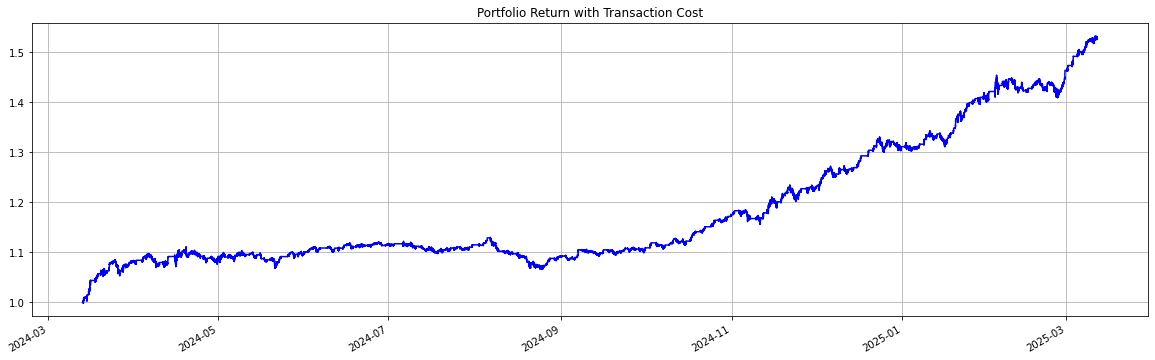

In [ ]:
raw_data=pd.read_pickle('data/USDT_KRW_20250311.pkl')

SMA_window = 60 * 24 *1  # 하루
SD_window = SMA_window
LB_threshold = 1
UB_threshold = 1
transaction_cost = 0.0004
############################################################
SMA = raw_data['K_prem(%)'].rolling(SMA_window).mean()
SD = raw_data['K_prem(%)'].rolling(SD_window).std()
raw_data['SMA'] = SMA                  #premium SMA
raw_data['LB']= SMA - LB_threshold*SD  #premium lower band
raw_data['UB']= SMA + UB_threshold*SD  #premium upper band
raw_data_dropna=raw_data.dropna().copy()
raw_data_dropna['close_LB']= raw_data_dropna['MID_PRICE'] * (1+raw_data_dropna['LB']/100)
raw_data_dropna['close_LB_floor']= np.floor(raw_data_dropna['close_LB'])
raw_data_dropna['close_UB']= raw_data_dropna['MID_PRICE'] * (1+raw_data_dropna['UB']/100)
raw_data_dropna['close_UB_ceil']= np.ceil(raw_data_dropna['close_UB'])

# 1. 매매 시그널 생성
    # t-1 시점에 close가 close_LB 보다 높은 상태에서
    # t-1 값을 기반으로 close_LB floor(t-1)가격에 t시점 동안 매수주문, t시점 low가 close_LB floor(t-1)가격 이하라면 lose_LB floor(t-1)가격에 진입 확정
Buy_DownsideBreakout=np.where(
    ( (raw_data_dropna['close'].shift(1)>raw_data_dropna['close_LB'].shift(1))
     &(raw_data_dropna['low']<=raw_data_dropna['close_LB_floor'].shift(1)) ).fillna(False),
    1,
    0
    )
raw_data_dropna['Buy_DownsideBreakout']= Buy_DownsideBreakout

    # t-1 시점에 close가 close_UB 보다 낮은 상태에서
    # t-1 값을 기반으로 close_UB ceil(t-1)가격에 t시점 동안 매도주문, t시점 high가 close_UB ceil(t-1)가격 이상이라면  close_UB ceil(t-1)가격에 청산 확정
Sell_UpSideBreakout=np.where(
    ( (raw_data_dropna['close'].shift(1)<raw_data_dropna['close_UB'].shift(1))
     &(raw_data_dropna['high']>=raw_data_dropna['close_UB_ceil'].shift(1)) ).fillna(False),
    1,
    0
    )
raw_data_dropna['Sell_UpSideBreakout']= Sell_UpSideBreakout


# 2. 포지션 계산
# 신호를 기반으로 거래 이벤트 생성 (Buy: +1, Sell: -1)
raw_data_dropna['Trade_Signal'] = raw_data_dropna['Buy_DownsideBreakout'] - raw_data_dropna['Sell_UpSideBreakout']

raw_data_dropna['Position'] = 0
# 매수 시그널 시점 1, 매도 시그널 시점 0으로 설정, 시그널 발생이 없을 경우 pd.NA로 설정
raw_data_dropna['Position'] = np.where(raw_data_dropna['Trade_Signal']==1, 
                                        1,
                                        np.where(raw_data_dropna['Trade_Signal']==-1, 
                                                0,
                                                pd.NA
                                                )
                                       )
# ffill로 앞의 포지션이 다른 시그널이 나올때까지 유지, 첫 번째 값은 0으로 설정
raw_data_dropna['Position'] = raw_data_dropna['Position'].ffill().fillna(0).astype(int)

# 3. 수익률 계산
portfolio_return_before_TransactionCost = raw_data_dropna['Position']*(raw_data_dropna['close'].pct_change())
portfolio_return_before_TransactionCost.iloc[0] = 0

portfolio_return_after_TransactionCost= portfolio_return_before_TransactionCost.copy()
    # 포지션 오픈 시 거래 비용을 고려한 수익률 계산
position_open_boolean=(raw_data_dropna['Trade_Signal']==1)&(raw_data_dropna['Position'].shift(1)==0)
# t-1 값을 기반으로 close_LB floor(t-1)가격에 t시점 동안 매수주문, t시점 low가 close_LB floor(t-1)가격보다 낮다면 진입 확정
position_open_return_with_TransactionCost=raw_data_dropna['close']/raw_data_dropna['close_LB_floor'].shift(1)-1-transaction_cost
portfolio_return_after_TransactionCost[position_open_boolean]=position_open_return_with_TransactionCost[position_open_boolean]
    # 포지션 청산 시 거래 비용을 고려한 수익률 계산
position_close_boolean=(raw_data_dropna['Trade_Signal']==-1)&(raw_data_dropna['Position'].shift(1)==1)
position_close_return_with_TransactionCost=raw_data_dropna['close_UB_ceil']/raw_data_dropna['close'].shift(1)-1-transaction_cost
portfolio_return_after_TransactionCost[position_close_boolean]=position_close_return_with_TransactionCost[position_close_boolean]

entry_price=raw_data_dropna['close_LB_floor'].shift(1)[position_open_boolean]
close_price=raw_data_dropna['close_UB_ceil'].shift(1)[position_close_boolean]
################################################################################################################################################
(portfolio_return_after_TransactionCost+1).cumprod().plot(figsize=(20, 6), title='Portfolio Return with Transaction Cost', color='blue')
plt.grid()

transaction_log=(close_price.values/(entry_price[:len(close_price)]).values-1-transaction_cost)

print('총거래 수:',position_close_boolean.sum())
print('승률:',round(len(transaction_log[transaction_log>=0])/len(transaction_log),3)*100,'%')
print('손익비',round(np.mean(transaction_log[transaction_log>=0])/abs(np.mean(transaction_log[transaction_log<0])),2))
print('거래당 평균수익률:',round(np.mean(transaction_log),4)*100,'%')

pfl_value=(portfolio_return_after_TransactionCost+1).cumprod()
CAGR=pfl_value[-1]/pfl_value[0]-1
Sigma=pfl_value.resample('ME').last().pct_change().dropna().std()*np.sqrt(12)
print('월간 샤프지수[rf=0]:',round(CAGR/Sigma,2))

pfl_value_cummmax= pfl_value.cummax()
drawdown=(pfl_value/pfl_value_cummmax-1)
MDD= drawdown.min()
print('포트폴리오 최대낙폭[minute]:',round(MDD,4)*100,'%')
print('누적수익률:', round(CAGR*100,2), '%')
print('CAGR:', round(CAGR*100,2), '%')

In [ ]:
# 아래 부분 진입과 청산시점에 거래비용 포함해도 승률이 거의 100%가 나오는 부분이 좀.... 오류인가? 아니면 mean reversion인가?

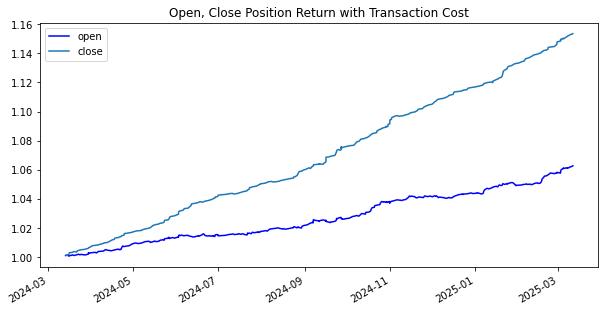

In [54]:
(position_open_return_with_TransactionCost[position_open_boolean]+1).cumprod().plot(figsize=(10, 5), title='Open, Close Position Return with Transaction Cost', color='blue')
(position_close_return_with_TransactionCost[position_close_boolean]+1).cumprod().plot()
plt.legend(['open','close'])

In [ ]:
# 기타 아이디어

In [ ]:
# set regime
regime=pd.Series(np.zeros(len(raw_data)),index=raw_data.index)
regime[raw_data['K_prem(%)']<-2.5]=-4
regime[(raw_data['K_prem(%)']>=-2.5) & (raw_data['K_prem(%)']<-1.5)]=-3
regime[(raw_data['K_prem(%)']>=-1.5) & (raw_data['K_prem(%)']<-0.5)]=-2
regime[(raw_data['K_prem(%)']>=-0.5) & (raw_data['K_prem(%)']<0)]=-1
regime[(raw_data['K_prem(%)']>=0) & (raw_data['K_prem(%)']<0.5)]=0
regime[(raw_data['K_prem(%)']>=0.5) & (raw_data['K_prem(%)']<1.5)]=1
regime[(raw_data['K_prem(%)']>=1.5) & (raw_data['K_prem(%)']<2.5)]=2 #유학생 아비트라지권
regime[(raw_data['K_prem(%)']>=2.5) & (raw_data['K_prem(%)']<3.5)]=3 # 카드 아비트라지권
regime[(raw_data['K_prem(%)']>=3.5) & (raw_data['K_prem(%)']<4.5)]=4 # 카드 아비트라지 수익권
regime[(raw_data['K_prem(%)']>=4.5) & (raw_data['K_prem(%)']<5.5)]=5 # 누구든 아비트라지 수익권
regime[(raw_data['K_prem(%)']>=5.5)]=6  # 초과열 
regime=regime.astype(int)
raw_data['regime']=regime